In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import numpy as np
from frames import FileVideoStream, FPS

In [2]:
# PyTorch Hub Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5n - yolov5x6, custom
model.classes = [2,3,5,7]


Using cache found in /home/mat/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-10-25 Python-3.10.6 torch-1.12.1+cu102 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [3]:
'''import os
from os import listdir
from os.path import isfile, join

path = './videos/'
filelist = [] #lista de los paths de cada frame

for i in range(2, 729):
    path = f"./videos/outputs{i}"
    for f in listdir(path):
        fpath = path + "/" + f
        filelist.append(fpath)'''

'import os\nfrom os import listdir\nfrom os.path import isfile, join\n\npath = \'./videos/\'\nfilelist = [] #lista de los paths de cada frame\n\nfor i in range(2, 729):\n    path = f"./videos/outputs{i}"\n    for f in listdir(path):\n        fpath = path + "/" + f\n        filelist.append(fpath)'

#### Classe Tracker y Target_car

In [4]:
class Target_car:
    def __init__(self, xmin, ymin, xmax, ymax):
        self.id_bb = None
        self.xmin= xmin
        self.ymin= ymin
        self.xmax= xmax
        self.ymax= ymax
        self.count= 0
        self.tracking = []

    def set_coord(self, xmin, ymin, xmax, ymax):
        self.xmin= xmin
        self.ymin= ymin
        self.xmax= xmax
        self.ymax= ymax

    def increase_counter(self):
        self.counter+=1

    def add_tracking(self, xmin, ymin, xmax, ymax):
        bb = {"xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax}
        self.tracking.append(bb)

    def IoU(self, xmin2, ymin2, xmax2, ymax2):
        x_inter1 = max(self.xmin, xmin2)
        y_inter1 = max(self.ymin, ymin2)
        x_inter2 = min(self.xmax, xmax2)
        y_inter2 = min(self.ymax, ymax2)

        width_inter = abs(x_inter2 - x_inter1)
        height_inter = abs(y_inter2 - y_inter1)
        area_inter = width_inter * height_inter

        width_box1 = abs(self.xmax - self.xmin)
        height_box1 = abs(self.ymax - self.ymin)

        width_box2 = abs(xmax2 - xmin2)
        height_box2 = abs(ymax2 - ymin2)

        area_box1 = width_box1 * height_box1
        area_box2 = width_box2 * height_box2

        area_union = area_box1 + area_box2 - area_inter

        iou= area_inter / area_union

        return iou

class Frame:
    def __init__(self):
        self.list_target_cars = []
    
    def load_targets_car(self, df):
        for i in df.index: 
            target_car = Target_car(int(df["xmin"][i]), int(df["ymin"][i]), int(df["xmax"][i]), int(df["ymax"][i]))
            target_car.id_bb = i
            target_car.add_tracking(target_car.xmin, target_car.ymin, target_car.xmax, target_car.ymax)
            self.list_target_cars.append(target_car) # [{id1: object_Target_car1},{id2: object_Target_car2}, ..., {idn: object_Target_carn}]

In [7]:
import time


class Tracker:
    def __init__(self, video_path= "/videos/output7.mp4",fps = 30):
        self.fps = fps
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print("Total frames: ", self.total_frames)
        self.list_tracking = []


    def generator(self, sample_rate=1, epsilon = 0.9, max_not_appear = 1):
        iters = 5 #numero de frames que vamos a hacerle el tracking (solo ha sido para hacer comprobaciones, luego desparecerá pq lo haremos con todos los frames)
        iteration = 0 #iteración en la que estamos
        same_targets_car = [] #lista de objetos de target_car que harán match con la "lista_original"

        for fno in range(0, int(self.total_frames/10), sample_rate):
            print(f" ---------- ITERACIÓ {iteration} ---------- ")

            self.cap.set(cv2.CAP_PROP_POS_FRAMES, fno)
            _, image = self.cap.read()
            result_frame = model(image)
            resultPd_frame = result_frame.pandas().xyxy[0] #pandas del resultado del primer frame


            if iteration == 0: 
                first_frame = Frame() #creamos un objeto frame
                first_frame.load_targets_car(resultPd_frame)
                self.list_tracking = first_frame.list_target_cars #Si estem a la primera iteració, no habrá que comparar con nada
                last_num_id = len(self.list_tracking) #para saber el último id que hemos añadido y tener control

            else: 
                frame_tmp = Frame() #creamos el "frame temporal" que se mirará si hace match con la lista de la iteración anterior (self.list_tracking)
                frame_tmp.load_targets_car(resultPd_frame)

                for bb_f1 in self.list_tracking: #per totes les bb de la lista de tracking (iteració anterior)
                    print("Calculem IoU de les bb amb la bb amb id = ", bb_f1.id_bb)
                    iou_max= 0 #partimos de un iou malo

                    for bb_f2 in frame_tmp.list_target_cars: #per totes les bb del frame tmp
                        iou= bb_f1.IoU(bb_f2.xmin, bb_f2.ymin, bb_f2.xmax, bb_f2.ymax) #calculamos la IoU de las bb de la iteración anterior con los de la nueva

                        if iou > iou_max and iou >= epsilon:
                            iou_max = iou
                            bb_match = bb_f2 #hace match!!
                    
                    if iou_max != 0: #Si hemos encontrado un buen IoU, y por lo tanto ha hecho match
                        bb_match.count==0 #assignamos el contador a 0
                        bb_f1.add_tracking(bb_match.xmin, bb_match.ymin, bb_match.xmax, bb_match.ymax) #añadimos las coordenadas al tracking del objeto
                        bb_f1.set_coord(bb_match.xmin, bb_match.ymin, bb_match.xmax, bb_match.ymax) #cambiamos las nuevas coordenadas al objeto que hace referencia
                        same_targets_car.append(bb_match) #añadimos el objeto que hace match a la lista de same_targets_car

                        print(iou_max, "MATCH")

                    
                    else:
                        print(iou_max, "FALSE")
                        bb_f1.count+=1 #Como no ha hecho más sumamos 1

        
                #Encontramos los elementos que no se han encontrado pasados max_not_appear (num de iteraciones maximas que damos por perdido el objeto)
                new_list_tracking= [] #crearemos la lista que será nuestra self.list_tracking al haver hecho toda la iteración
                for element in self.list_tracking:
                    if element.count < max_not_appear: #Si el elemento se ha encontrado antes de max_not_appear iteraciones
                        new_list_tracking.append(element) #permanece en la lista


                #Encontramos los bounding box del frame temporal que no han hecho match con los que ya había en la iteración anterior
                new_targets_car = [x for x in frame_tmp.list_target_cars if x not in same_targets_car] #son "nuevos cotxes" que no habían aparecido en el vídeo anteriormente



                for element in new_targets_car: #añadimos a la nueva lista los elementos nuevos
                    element.id_bb = (last_num_id + 1) #le asignamos un nuevo id característico
                    new_list_tracking.append(element)

            
                self.list_tracking = new_list_tracking #nueva self.list_tracking que se utilizará en la próxima iter


            if iteration== iters:
                #print(self.list_tracking)
                break
            else: iteration+=1
    
    def generator_optimized(self, sample_rate=1, epsilon = 0.9, max_not_appear = 1):

        t = 0
        last_num_id = 0

        fvs = FileVideoStream(self.video_path,fps = self.fps).start()
        time.sleep(1.0)
        # start the FPS timer
        fps = FPS().start()

        iters = 200 #numero de frames que vamos a hacerle el tracking (solo ha sido para hacer comprobaciones, luego desparecerá pq lo haremos con todos los frames)
        iteration = 0 #iteración en la que estamos
        same_targets_car = [] #lista de objetos de target_car que harán match con la "lista_original"

        while(fvs.more()):

            frame = fvs.read()
            #frame = imutils.resize(frame, width=450)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = np.dstack([frame, frame, frame])

            # crop del frame para que solo se vea la zona de interes
            frame = frame[600:,50:450,:]


            print(f" ---------- ITERACIÓ {iteration} ---------- ")

            

            #self.cap.set(cv2.CAP_PROP_POS_FRAMES, fno)
            #_, image = self.cap.read()
            t0 = time.time()
            result_frame = model(frame)
            t+= time.time()-t0

            # if iteration == 3:
            #     result_frame.show()
            resultPd_frame = result_frame.pandas().xyxy[0] #pandas del resultado del primer frame
            
            

            if iteration == 0: 
                first_frame = Frame() #creamos un objeto frame
                first_frame.load_targets_car(resultPd_frame)
                self.list_tracking = first_frame.list_target_cars #Si estem a la primera iteració, no habrá que comparar con nada
                last_num_id = len(self.list_tracking) #para saber el último id que hemos añadido y tener control

            else: 
                frame_tmp = Frame() #creamos el "frame temporal" que se mirará si hace match con la lista de la iteración anterior (self.list_tracking)
                frame_tmp.load_targets_car(resultPd_frame)

                match = False #variable que nos dirá si ha hecho match o no

                for bb_f1 in self.list_tracking: #per totes les bb de la lista de tracking (iteració anterior)
                    print("Calculem IoU de les bb amb la bb amb id = ", bb_f1.id_bb)
                    iou_max= 0 #partimos de un iou malo

                    for bb_f2 in frame_tmp.list_target_cars: #per totes les bb del frame tmp
                        iou= bb_f1.IoU(bb_f2.xmin, bb_f2.ymin, bb_f2.xmax, bb_f2.ymax) #calculamos la IoU de las bb de la iteración anterior con los de la nueva

                        if iou > iou_max and iou >= epsilon:
                            iou_max = iou
                            bb_match = bb_f2 #hace match!!
                    
                    if iou_max != 0: #Si hemos encontrado un buen IoU, y por lo tanto ha hecho match
                        bb_match.count==0 #assignamos el contador a 0
                        bb_f1.add_tracking(bb_match.xmin, bb_match.ymin, bb_match.xmax, bb_match.ymax) #añadimos las coordenadas al tracking del objeto
                        bb_f1.set_coord(bb_match.xmin, bb_match.ymin, bb_match.xmax, bb_match.ymax) #cambiamos las nuevas coordenadas al objeto que hace referencia
                        same_targets_car.append(bb_match) #añadimos el objeto que hace match a la lista de same_targets_car

                        print(iou_max, "MATCH")

                        match = True #hemos hecho match

                    
                    else:
                        print(iou_max, "FALSE")
                        bb_f1.count+=1 #Como no ha hecho más sumamos 1

                # if match:
                #     result_frame.show()

        
                #Encontramos los elementos que no se han encontrado pasados max_not_appear (num de iteraciones maximas que damos por perdido el objeto)
                new_list_tracking= [] #crearemos la lista que será nuestra self.list_tracking al haver hecho toda la iteración
                for element in self.list_tracking:
                    if element.count < max_not_appear: #Si el elemento se ha encontrado antes de max_not_appear iteraciones
                        new_list_tracking.append(element) #permanece en la lista


                #Encontramos los bounding box del frame temporal que no han hecho match con los que ya había en la iteración anterior
                new_targets_car = [x for x in frame_tmp.list_target_cars if x not in same_targets_car] #son "nuevos cotxes" que no habían aparecido en el vídeo anteriormente

                for element in new_targets_car: #añadimos a la nueva lista los elementos nuevos
                    last_num_id+=1
                    element.id_bb = (last_num_id) #le asignamos un nuevo id característico
                    new_list_tracking.append(element)

            
                self.list_tracking = new_list_tracking #nueva self.list_tracking que se utilizará en la próxima iter

            # actualitzar el FPS counter
            fps.update()

            if iteration== iters:
                #print(self.list_tracking)
                break
            else: iteration+=1
        
        print("AI model time: ", t)


#### Video

Total frames:  7288
1
30.0
30.0
 ---------- ITERACIÓ 0 ---------- 
 ---------- ITERACIÓ 1 ---------- 
 ---------- ITERACIÓ 2 ---------- 
 ---------- ITERACIÓ 3 ---------- 


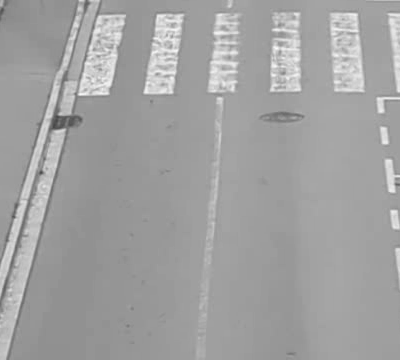

 ---------- ITERACIÓ 4 ---------- 
 ---------- ITERACIÓ 5 ---------- 
 ---------- ITERACIÓ 6 ---------- 
 ---------- ITERACIÓ 7 ---------- 
 ---------- ITERACIÓ 8 ---------- 
 ---------- ITERACIÓ 9 ---------- 
 ---------- ITERACIÓ 10 ---------- 
 ---------- ITERACIÓ 11 ---------- 
 ---------- ITERACIÓ 12 ---------- 
 ---------- ITERACIÓ 13 ---------- 
 ---------- ITERACIÓ 14 ---------- 
 ---------- ITERACIÓ 15 ---------- 
 ---------- ITERACIÓ 16 ---------- 
 ---------- ITERACIÓ 17 ---------- 
 ---------- ITERACIÓ 18 ---------- 
 ---------- ITERACIÓ 19 ---------- 
 ---------- ITERACIÓ 20 ---------- 
 ---------- ITERACIÓ 21 ---------- 
 ---------- ITERACIÓ 22 ---------- 
 ---------- ITERACIÓ 23 ---------- 
 ---------- ITERACIÓ 24 ---------- 
 ---------- ITERACIÓ 25 ---------- 
 ---------- ITERACIÓ 26 ---------- 
 ---------- ITERACIÓ 27 ---------- 
 ---------- ITERACIÓ 28 ---------- 
 ---------- ITERACIÓ 29 ---------- 
 ---------- ITERACIÓ 30 ---------- 
 ---------- ITERACIÓ 31 ----------

In [8]:
tracking = Tracker("videos/output7.mp4",fps = 1)
tracking.generator_optimized()